In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import os, glob
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn import svm
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import f1_score
np.random.seed(1234)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<h1>Data Laoding</h1>

In [2]:
with open('trainset_python/python/class_names.txt') as f:
    classes = f.readlines()

for i,c in enumerate(classes):
    classes[i] = c.strip()

In [3]:
with open('trainset_python/python/feature_names.txt') as f:
    features = f.readlines()

for i,feature in enumerate(features):
    features[i] = feature.strip()

In [4]:
#all files in one dataframe
idx = pd.Series([i for i in range(100)])

rootdir = os. getcwd()
files = pd.DataFrame([])
files_stand = pd.DataFrame([])
lables = pd.DataFrame([])
data = pd.DataFrame([])
data_stand = pd.DataFrame([])
    
for i,f in enumerate(glob.glob(rootdir + '/**/*.npy', recursive=True)):
    if (i % 2) == 0:
        lable = pd.DataFrame(np.load(f))
        #lable = lable.rename(columns={lable.columns[0]: "overall_class"})
        for i, col in enumerate(lable.columns):
            if i == 0:
                lable = lable.rename(columns={lable.columns[0]: "overall_class_vote"})
            else:
                lable = lable.rename(columns={col: "class_vote_" + str(i)})
        if lables.empty:
            lables = lable
        else:
            idx = idx + (i*100)
            lable.index = idx
            lables = lables.append(lable)
    else:
        file = pd.DataFrame(np.load(f), columns = features)
        file_stand = pd.DataFrame(StandardScaler().fit_transform(np.load(f)), columns = features)
        if files.empty:
            files = file
        else:
            idx = idx + (i*100)
            file.index = idx
            files = files.append(file)
        if files_stand.empty:
            files_stand = file_stand
        else:
            idx = idx + (i*100)
            file_stand.index = idx
            files_stand = files_stand.append(file_stand)


lables.index = pd.Series([i for i in range(len(lables))])
files.index = pd.Series([i for i in range(len(lables))])
files_stand.index = pd.Series([i for i in range(len(lables))])

In [5]:
file_stand_incl_labels = pd.concat([files_stand, lables], axis=1, join='inner')

<h1>Sample data</h1>

In [6]:
import math

def sample_dataframe_by_threshold(file_stand_incl_labels, lables):
    dropped_indices = []
    nr_annotators = [0, 0, 0, 0, 0]

    invalid_samples = 0
    for i, sample in enumerate(file_stand_incl_labels.copy().to_numpy()[:, -7:]):
        sample_has_nans = 0
        sample_nan_idx = []
        for l, val in enumerate(sample):
            if math.isnan(val):
                sample_nan_idx.append(l)
                sample_has_nans += 1
        # remove nans from sample
        sample = np.delete(sample, sample_nan_idx)
        # print(sample)
        classes_vote = [np.count_nonzero((sample == 1) | (sample == 1.0)), np.count_nonzero((sample == 2) | (sample == 2.0)), np.count_nonzero((sample == 3) | (sample == 3.0)),
                        np.count_nonzero((sample == 4) | (sample == 4.0)), np.count_nonzero((sample == 5) | (sample == 5.0)), np.count_nonzero((sample == 6) | (sample == 6.0))]
        # accept fragments with no votes and votes above current threshold
        if np.max(classes_vote) / len(sample) > 0:
            #accept all samples for 3 annotators
            if len(sample) == 4 and np.max(classes_vote) / len(sample) < 3/4:
                invalid_samples += 1
                dropped_indices.append(i)
            elif len(sample) == 5 and np.max(classes_vote) / len(sample) < 3/5:
                invalid_samples += 1
                dropped_indices.append(i)
            elif len(sample) == 6 and np.max(classes_vote) / len(sample) < 4/6:
                invalid_samples += 1
                dropped_indices.append(i)
            elif len(sample) == 7 and np.max(classes_vote) / len(sample) < 5/7:
                invalid_samples += 1
                dropped_indices.append(i)
    # drop the samples with < threshold than selected
    sampled_dataframe = file_stand_incl_labels.drop(dropped_indices).reset_index()
    lables_agree = lables.drop(dropped_indices).reset_index()
    lables_agree = lables_agree.iloc[:, 1:]
    # drop vote columns and index_column
    sampled_dataframe = sampled_dataframe.iloc[:, 1:-8]
    return sampled_dataframe, lables_agree

In [7]:
files_agree, lables_agree = sample_dataframe_by_threshold(file_stand_incl_labels, lables)

In [8]:
files_agree

,zcr_mean,zcr_std,yin_0,yin_1,yin_2,yin_3,yin_4,yin_5,yin_6,yin_7,...,cln_contrast_mean_4,cln_contrast_mean_5,cln_contrast_mean_6,cln_contrast_std_0,cln_contrast_std_1,cln_contrast_std_2,cln_contrast_std_3,cln_contrast_std_4,cln_contrast_std_5,cln_contrast_std_6
0,0.167208,-0.526000,-0.605283,-0.644997,-0.667503,-0.714700,-0.783143,-0.637137,-0.684710,-0.702930,...,-1.427318,0.074920,-0.115683,0.804020,1.606063,-1.114032,-0.851041,-0.778650,-0.453525,0.479612
1,0.461319,-0.636900,-0.578792,-0.649733,-0.671045,-0.717349,-0.780945,-0.636216,-0.683018,-0.700525,...,-0.224404,-0.914364,-0.323859,-1.849531,1.352744,-0.486672,-1.106791,-0.014905,-0.742246,0.318966
2,0.854948,-0.895040,-0.577355,-0.647228,1.701700,1.539210,1.367054,1.740341,1.636040,1.694016,...,-0.778076,-0.928394,-0.319547,-0.412680,0.388380,0.980363,-0.796871,-0.166418,-1.076733,-0.265297
3,0.822960,-0.542231,-0.608296,1.754146,1.784766,1.610830,1.431633,1.783958,1.649853,1.716896,...,-1.623868,-1.209971,-0.311791,-0.557688,-0.121353,1.415610,-0.072873,-0.584790,-0.472864,-0.260567
4,1.185489,-0.650381,1.920336,1.733858,1.769065,1.630653,1.431748,1.716913,1.575559,1.648439,...,-0.204925,-1.441965,0.677037,-0.175322,-0.255244,0.513171,-1.169459,-0.658233,-0.090633,0.319449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99743,-0.331513,0.356134,-0.844403,-0.858645,-0.641962,-0.805758,-0.697388,-0.642756,-0.856450,-0.796840,...,-0.286449,-0.457386,-0.313910,1.092455,-1.203601,0.934860,-0.202530,-0.613064,0.010541,0.138739
99744,-1.220233,-0.828050,-0.903588,-0.687250,-0.680983,-0.653949,-0.680398,-0.549913,-0.753115,-0.687278,...,0.024849,-0.176945,-0.326877,0.339264,0.115136,-0.538031,1.039460,0.106102,-0.789529,0.160393
99745,-0.438986,-0.523291,-0.908066,-0.808672,-0.801250,-0.614802,-0.844231,-0.732196,-0.812538,-0.531270,...,0.102378,-0.428485,-0.163334,-0.339807,1.281501,1.089032,0.429298,0.445736,-0.984278,-0.468615
99746,-0.856478,-0.580928,-0.195463,-0.084748,-0.035737,-0.576595,-0.475360,-0.519312,-0.610353,-0.561646,...,-0.584563,-0.117808,-0.142838,-0.283224,-0.190104,-0.195900,0.225551,-1.174491,-0.516408,0.472931


In [9]:
lables_agree

,overall_class_vote,class_vote_1,class_vote_2,class_vote_3,class_vote_4,class_vote_5,class_vote_6,class_vote_7
0,0,0,0,0,0.0,0.0,0.0,NaN
1,0,0,0,0,0.0,0.0,0.0,NaN
2,0,0,0,0,0.0,0.0,0.0,NaN
3,0,0,0,0,0.0,0.0,0.0,NaN
4,0,0,0,0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...
99743,0,0,0,0,0.0,0.0,0.0,NaN
99744,0,0,0,0,0.0,0.0,0.0,NaN
99745,0,0,0,0,0.0,0.0,0.0,NaN
99746,0,0,0,0,0.0,0.0,0.0,NaN


<h1>Drop correlated features</h1>

In [10]:
# drop highly correlated features
cor_stand = files_agree.corr()

# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(corr_matrix, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features_stand = correlation(cor_stand, 0.9)
files_agree = files_agree.drop(corr_features_stand,axis=1)

In [11]:
files_agree

,zcr_mean,zcr_std,yin_0,yin_1,yin_2,yin_3,yin_4,yin_5,yin_6,yin_7,...,cln_contrast_mean_4,cln_contrast_mean_5,cln_contrast_mean_6,cln_contrast_std_0,cln_contrast_std_1,cln_contrast_std_2,cln_contrast_std_3,cln_contrast_std_4,cln_contrast_std_5,cln_contrast_std_6
0,0.167208,-0.526000,-0.605283,-0.644997,-0.667503,-0.714700,-0.783143,-0.637137,-0.684710,-0.702930,...,-1.427318,0.074920,-0.115683,0.804020,1.606063,-1.114032,-0.851041,-0.778650,-0.453525,0.479612
1,0.461319,-0.636900,-0.578792,-0.649733,-0.671045,-0.717349,-0.780945,-0.636216,-0.683018,-0.700525,...,-0.224404,-0.914364,-0.323859,-1.849531,1.352744,-0.486672,-1.106791,-0.014905,-0.742246,0.318966
2,0.854948,-0.895040,-0.577355,-0.647228,1.701700,1.539210,1.367054,1.740341,1.636040,1.694016,...,-0.778076,-0.928394,-0.319547,-0.412680,0.388380,0.980363,-0.796871,-0.166418,-1.076733,-0.265297
3,0.822960,-0.542231,-0.608296,1.754146,1.784766,1.610830,1.431633,1.783958,1.649853,1.716896,...,-1.623868,-1.209971,-0.311791,-0.557688,-0.121353,1.415610,-0.072873,-0.584790,-0.472864,-0.260567
4,1.185489,-0.650381,1.920336,1.733858,1.769065,1.630653,1.431748,1.716913,1.575559,1.648439,...,-0.204925,-1.441965,0.677037,-0.175322,-0.255244,0.513171,-1.169459,-0.658233,-0.090633,0.319449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99743,-0.331513,0.356134,-0.844403,-0.858645,-0.641962,-0.805758,-0.697388,-0.642756,-0.856450,-0.796840,...,-0.286449,-0.457386,-0.313910,1.092455,-1.203601,0.934860,-0.202530,-0.613064,0.010541,0.138739
99744,-1.220233,-0.828050,-0.903588,-0.687250,-0.680983,-0.653949,-0.680398,-0.549913,-0.753115,-0.687278,...,0.024849,-0.176945,-0.326877,0.339264,0.115136,-0.538031,1.039460,0.106102,-0.789529,0.160393
99745,-0.438986,-0.523291,-0.908066,-0.808672,-0.801250,-0.614802,-0.844231,-0.732196,-0.812538,-0.531270,...,0.102378,-0.428485,-0.163334,-0.339807,1.281501,1.089032,0.429298,0.445736,-0.984278,-0.468615
99746,-0.856478,-0.580928,-0.195463,-0.084748,-0.035737,-0.576595,-0.475360,-0.519312,-0.610353,-0.561646,...,-0.584563,-0.117808,-0.142838,-0.283224,-0.190104,-0.195900,0.225551,-1.174491,-0.516408,0.472931


<h1>Select K best features</h1>

In [12]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

#twenty_cols = SelectKBest(mutual_info_classif, k=20)
#twenty_cols.fit(files_agree, lables_agree['overall_class_vote'])
#selected_features_20 = files_agree.columns[twenty_cols.get_support()]

In [13]:
#pd.DataFrame(selected_features_20)

In [14]:
"""files_chosen_20 = pd.DataFrame()

for idx in selected_features_20:
    files_chosen_20[idx] = files_agree[idx]"""

'files_chosen_20 = pd.DataFrame()\n\nfor idx in selected_features_20:\n    files_chosen_20[idx] = files_agree[idx]'

In [15]:
#files_chosen_20

In [16]:
"""files_chosen_50 = pd.DataFrame()

for idx in selected_features_50:
    files_chosen_50[idx] = files_agree[idx]"""

'files_chosen_50 = pd.DataFrame()\n\nfor idx in selected_features_50:\n    files_chosen_50[idx] = files_agree[idx]'

In [17]:
#files_chosen_50

<h1>Train-Test-Split</h1>

In [18]:
#X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(files_chosen_20,lables_agree['overall_class_vote'],test_size = 0.2,stratify=lables_agree['overall_class_vote'], random_state=42)

#X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(files_chosen_50,lables_agree['overall_class_vote'],test_size = 0.2,stratify=lables_agree['overall_class_vote'], random_state=42)

#X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(files_agree,lables_agree['overall_class_vote'],test_size = 0.2,stratify=lables_agree['overall_class_vote'], random_state=42)

<h1>SVM Classifier for 20 features</h1>

In [19]:
"""linear_classifier = svm.SVC(kernel='linear', random_state=42)

linear_classifier.fit(X_train_20, y_train_20)
# make prediction
linear_classif_predictions = linear_classifier.predict(X_test_20)
accuracy_score(linear_classif_predictions, y_test_20)"""

"linear_classifier = svm.SVC(kernel='linear', random_state=42)\n\nlinear_classifier.fit(X_train_20, y_train_20)\n# make prediction\nlinear_classif_predictions = linear_classifier.predict(X_test_20)\naccuracy_score(linear_classif_predictions, y_test_20)"

In [20]:
"""poly_classifier = svm.SVC(kernel='poly', random_state=42)

poly_classifier.fit(X_train_20, y_train_20)
# make prediction
poly_classif_predictions = poly_classifier.predict(X_test_20)
accuracy_score(poly_classif_predictions, y_test_20)"""

"poly_classifier = svm.SVC(kernel='poly', random_state=42)\n\npoly_classifier.fit(X_train_20, y_train_20)\n# make prediction\npoly_classif_predictions = poly_classifier.predict(X_test_20)\naccuracy_score(poly_classif_predictions, y_test_20)"

In [21]:
"""rbf_classifier = svm.SVC(kernel='rbf', random_state=42)

rbf_classifier.fit(X_train_20, y_train_20)
# make prediction
rbf_classif_predictions = rbf_classifier.predict(X_test_20)
accuracy_score(rbf_classif_predictions, y_test_20)"""

"rbf_classifier = svm.SVC(kernel='rbf', random_state=42)\n\nrbf_classifier.fit(X_train_20, y_train_20)\n# make prediction\nrbf_classif_predictions = rbf_classifier.predict(X_test_20)\naccuracy_score(rbf_classif_predictions, y_test_20)"

In [22]:
"""linear_classifier_f1 = f1_score(y_test_20, linear_classif_predictions, average='macro')
poly_classifier_f1 = f1_score(y_test_20, poly_classif_predictions, average='macro')
rbf_classifier_f1 = f1_score(y_test_20, rbf_classif_predictions, average='macro')"""

"linear_classifier_f1 = f1_score(y_test_20, linear_classif_predictions, average='macro')\npoly_classifier_f1 = f1_score(y_test_20, poly_classif_predictions, average='macro')\nrbf_classifier_f1 = f1_score(y_test_20, rbf_classif_predictions, average='macro')"

In [23]:
"""print(linear_classifier_f1)
print(poly_classifier_f1)
print(rbf_classifier_f1)"""

'print(linear_classifier_f1)\nprint(poly_classifier_f1)\nprint(rbf_classifier_f1)'

In [24]:
"""linear_classifier_f1 = f1_score(y_test_20, linear_classif_predictions, average='weighted')
poly_classifier_f1 = f1_score(y_test_20, poly_classif_predictions, average='weighted')
rbf_classifier_f1 = f1_score(y_test_20, rbf_classif_predictions, average='weighted')"""

"linear_classifier_f1 = f1_score(y_test_20, linear_classif_predictions, average='weighted')\npoly_classifier_f1 = f1_score(y_test_20, poly_classif_predictions, average='weighted')\nrbf_classifier_f1 = f1_score(y_test_20, rbf_classif_predictions, average='weighted')"

In [25]:
"""print(linear_classifier_f1)
print(poly_classifier_f1)
print(rbf_classifier_f1)"""

'print(linear_classifier_f1)\nprint(poly_classifier_f1)\nprint(rbf_classifier_f1)'

In [26]:
"""linear_classifier_f1 = f1_score(y_test_20, linear_classif_predictions, average='micro')
poly_classifier_f1 = f1_score(y_test_20, poly_classif_predictions, average='micro')
rbf_classifier_f1 = f1_score(y_test_20, rbf_classif_predictions, average='micro')"""

"linear_classifier_f1 = f1_score(y_test_20, linear_classif_predictions, average='micro')\npoly_classifier_f1 = f1_score(y_test_20, poly_classif_predictions, average='micro')\nrbf_classifier_f1 = f1_score(y_test_20, rbf_classif_predictions, average='micro')"

In [27]:
"""print(linear_classifier_f1)
print(poly_classifier_f1)
print(rbf_classifier_f1)"""

'print(linear_classifier_f1)\nprint(poly_classifier_f1)\nprint(rbf_classifier_f1)'

<h1>50 features</h1>

In [28]:
fifty_cols = SelectKBest(mutual_info_classif, k=50)
fifty_cols.fit(files_agree, lables_agree['overall_class_vote'])
selected_features_50 = files_agree.columns[fifty_cols.get_support()]

In [29]:
files_chosen_50 = pd.DataFrame()

for idx in selected_features_50:
    files_chosen_50[idx] = files_agree[idx]

In [30]:
files_chosen_50

,zcr_mean,raw_melspect_mean_4,raw_melspect_mean_5,raw_melspect_mean_6,raw_melspect_mean_7,raw_melspect_mean_8,raw_melspect_mean_9,raw_melspect_mean_10,raw_melspect_mean_11,raw_melspect_mean_12,...,raw_contrast_mean_3,cln_flatness_mean,cln_centroid_mean,cln_centroid_std,cln_flux_mean,cln_flux_std,cln_energy_std,cln_bandwidth_mean,cln_contrast_mean_3,cln_contrast_mean_4
0,0.167208,0.413676,0.351911,0.182678,-0.001713,-0.367584,-0.493130,-0.811764,-0.494151,-0.535799,...,-0.193519,0.623446,0.948781,-0.596810,-0.447192,-0.487065,-0.443302,-0.147406,-1.066098,-1.427318
1,0.461319,-0.855740,0.033231,-0.059496,-0.188944,-0.213440,0.041397,0.137262,0.020711,-0.150333,...,-0.444102,0.947370,0.847815,-0.609965,-0.548157,-0.530030,-0.363591,-0.271310,-1.044733,-0.224404
2,0.854948,0.191515,-0.750290,-0.783740,-0.732563,-0.692779,-0.414533,-1.120994,-0.896223,-0.951161,...,-0.664926,0.872882,1.227718,-0.055447,-0.612837,-0.637614,-0.269222,0.188035,-0.305408,-0.778076
3,0.822960,-0.165756,0.174313,-0.412357,-0.677561,-0.748280,-0.769436,-1.669452,-2.492285,-0.867254,...,-0.219770,1.150775,1.022415,-0.495100,-0.791180,-0.688336,-0.372902,0.320006,-0.382392,-1.623868
4,1.185489,0.244198,-0.320617,-0.825520,-0.931514,-0.686089,-1.062352,-1.561100,-0.029832,0.035515,...,-0.886440,0.438736,0.705754,-0.851837,-0.672211,-0.523607,-0.303215,0.116443,-0.754747,-0.204925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99743,-0.331513,0.688131,0.232498,-0.014584,0.781043,0.300814,0.781700,0.192967,-0.249391,-0.527454,...,-0.038263,0.313846,0.071795,-0.097555,-0.234323,-0.194769,-0.096655,0.412820,-0.184484,-0.286449
99744,-1.220233,1.402616,0.555731,-0.039212,0.328129,0.012447,0.277539,0.595299,0.264265,0.057460,...,-0.348975,0.149666,0.010778,-0.007063,-0.287017,-0.225641,-0.185162,1.113627,0.169436,0.024849
99745,-0.438986,0.461479,0.801244,0.357578,-0.329339,-0.725959,-0.480579,-0.321559,-0.241697,0.001902,...,-0.236202,0.280166,-0.123845,-0.243513,-0.284446,-0.230821,-0.306870,0.845862,-0.368649,0.102378
99746,-0.856478,-0.305130,-0.579203,-0.303088,-0.088837,0.512104,0.852607,0.421025,-0.099590,-0.649966,...,-0.322785,0.151287,-0.175674,-0.153192,-0.281631,-0.204688,-0.181617,0.901573,-0.186372,-0.584563


In [31]:
X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(files_chosen_50,lables_agree['overall_class_vote'],test_size = 0.2,stratify=lables_agree['overall_class_vote'], random_state=42)

In [32]:
"""linear_classifier_f50 = svm.SVC(kernel='linear', random_state=42)

linear_classifier_f50.fit(X_train_50, y_train_50)
# make prediction
linear_classif_predictions_f50 = linear_classifier_f50.predict(X_test_50)
accuracy_score(linear_classif_predictions_f50, y_test_50)"""

"linear_classifier_f50 = svm.SVC(kernel='linear', random_state=42)\n\nlinear_classifier_f50.fit(X_train_50, y_train_50)\n# make prediction\nlinear_classif_predictions_f50 = linear_classifier_f50.predict(X_test_50)\naccuracy_score(linear_classif_predictions_f50, y_test_50)"

In [33]:
"""poly_classifier_f50 = svm.SVC(kernel='poly', random_state=42)

poly_classifier_f50.fit(X_train_50, y_train_50)
# make prediction
poly_classif_predictions_f50 = poly_classifier_f50.predict(X_test_50)
accuracy_score(poly_classif_predictions_f50, y_test_50)"""

"poly_classifier_f50 = svm.SVC(kernel='poly', random_state=42)\n\npoly_classifier_f50.fit(X_train_50, y_train_50)\n# make prediction\npoly_classif_predictions_f50 = poly_classifier_f50.predict(X_test_50)\naccuracy_score(poly_classif_predictions_f50, y_test_50)"

In [34]:
"""rbf_classifier_f50 = svm.SVC(kernel='rbf', random_state=42)

rbf_classifier_f50.fit(X_train_50, y_train_50)
# make prediction
rbf_classif_predictions_f50 = rbf_classifier_f50.predict(X_test_50)
accuracy_score(rbf_classif_predictions_f50, y_test_50)"""

"rbf_classifier_f50 = svm.SVC(kernel='rbf', random_state=42)\n\nrbf_classifier_f50.fit(X_train_50, y_train_50)\n# make prediction\nrbf_classif_predictions_f50 = rbf_classifier_f50.predict(X_test_50)\naccuracy_score(rbf_classif_predictions_f50, y_test_50)"

In [35]:
"""linear_classifier_f1_f50 = f1_score(y_test_50, linear_classif_predictions_f50, average='macro')
poly_classifier_f1_f50 = f1_score(y_test_50, poly_classif_predictions_f50, average='macro')
rbf_classifier_f1_f50 = f1_score(y_test_50, rbf_classif_predictions_f50, average='macro')"""

"linear_classifier_f1_f50 = f1_score(y_test_50, linear_classif_predictions_f50, average='macro')\npoly_classifier_f1_f50 = f1_score(y_test_50, poly_classif_predictions_f50, average='macro')\nrbf_classifier_f1_f50 = f1_score(y_test_50, rbf_classif_predictions_f50, average='macro')"

In [36]:
"""print(linear_classifier_f1_f50)
print(poly_classifier_f1_f50)
print(rbf_classifier_f1_f50)"""

'print(linear_classifier_f1_f50)\nprint(poly_classifier_f1_f50)\nprint(rbf_classifier_f1_f50)'

In [37]:
svm_dict = {
    'kernel': ['rbf'],
    'gamma': ['auto'],
    'degree': [3, 5, 7, 9, 11, 13, 15, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    'tol': [1e-3]
}


In [38]:
from sklearn.model_selection import cross_validate,  StratifiedKFold
from sklearn.metrics import average_precision_score, make_scorer

ap = make_scorer(average_precision_score)

cross_validation = StratifiedKFold(n_splits=5)
accs_train = []
accs_cv = []

"""for kernel in svm_dict['kernel']:
    for gamma in svm_dict['gamma']:
        for tol in svm_dict['tol']:
            for degree in svm_dict['degree']:
                classifier = svm.SVC(kernel=kernel, gamma=gamma, degree=degree, tol=1e-3, random_state=42, cache_size=1024)
                classifier.fit(X_train_50, y_train_50)
                # make prediction
                pred = classifier.predict(X_test_50)
                accuracy_score(rbf_classif_predictions, y_test_20)
                print(f'Classifier with kernel={kernel}, degree={degree}, gamma={gamma}, tol={tol} -> accuracy = {acc_cv}')
                print(f'Classifier with kernel={kernel}, degree={degree}, gamma={gamma}, tol={tol} -> accuracy = {acc_train}')
                print()"""


"for kernel in svm_dict['kernel']:\n    for gamma in svm_dict['gamma']:\n        for tol in svm_dict['tol']:\n            for degree in svm_dict['degree']:\n                classifier = svm.SVC(kernel=kernel, gamma=gamma, degree=degree, tol=1e-3, random_state=42, cache_size=1024)\n                classifier.fit(X_train_50, y_train_50)\n                # make prediction\n                pred = classifier.predict(X_test_50)\n                accuracy_score(rbf_classif_predictions, y_test_20)\n                print(f'Classifier with kernel={kernel}, degree={degree}, gamma={gamma}, tol={tol} -> accuracy = {acc_cv}')\n                print(f'Classifier with kernel={kernel}, degree={degree}, gamma={gamma}, tol={tol} -> accuracy = {acc_train}')\n                print()"

In [39]:
accs_train

[]

In [40]:
accs_cv

[]

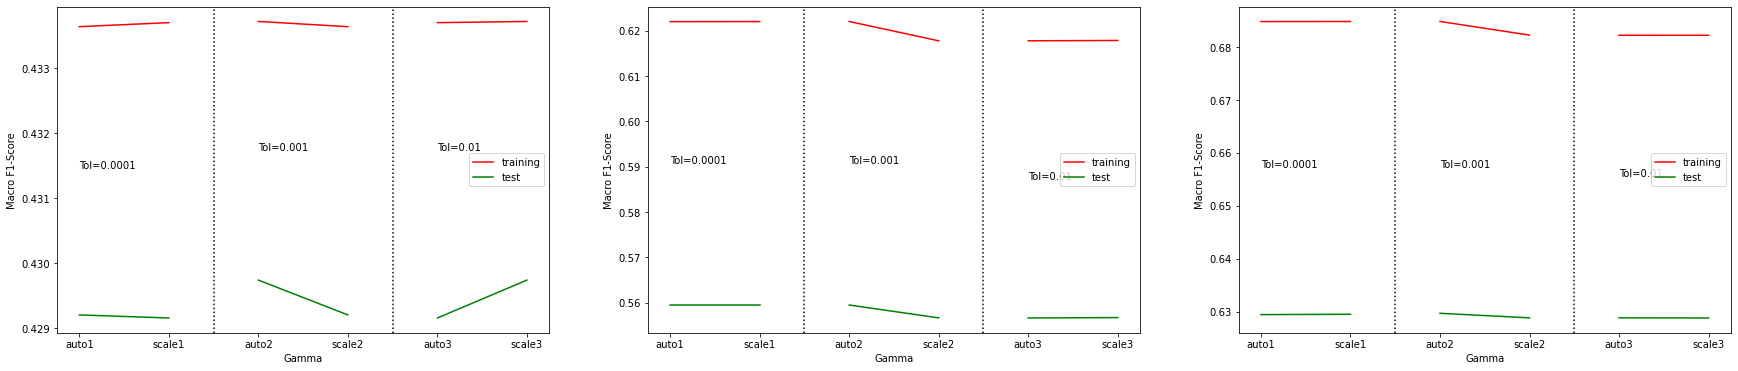

In [41]:
list_accs_cv_f20 = [0.4292043364914601, 0.429157236168379, 0.4297407755508459, 0.4292043364914601, 0.429157236168379, 0.4297407755508459, 0.5594302028437397, 0.5594302028437397, 0.5595133267895878,
                    0.5566779218702129, 0.5566570338774909, 0.5567433727382229, 0.6294297078832145, 0.6294927970623252, 0.6296740765511395, 0.6288166902986829, 0.6288237104320895, 0.6287918307277847]
list_accs_train_f20 = [0.4336433955325102, 0.4337055617155565, 0.43372363558328564, 0.4336433955325102, 0.4337055617155565, 0.43372363558328564, 0.6219952004339078, 0.6220160240762307, 0.6220351042289407,
                       0.617767146828768, 0.6177678186768427, 0.617848177606281, 0.684827702444599, 0.6848429456198822, 0.6848484469478047, 0.6822685195541487, 0.6822465763661392, 0.682242541342983]


list_accs_cv_f50 = [0.5887976606153424, 0.5887690550834879, 0.58848177267039, 0.5887976606153424, 0.5887690550834879, 0.58848177267039, 0.7118474913418011, 0.7118542502832009, 0.7119224330345231,
                    0.7111884629922562, 0.7111151097795588, 0.7111131516458598, 0.77338137836, 0.7733814008803476, 0.7733814008803476, 0.77339178738273, 0.77339863836183, 0.773472792793]
list_accs_train_f50 = [0.5955183602874777, 0.5955025395505328, 0.5955761079843741, 0.5955183602874777, 0.5955025395505328, 0.5955761079843741, 0.8119084621128307, 0.8119020498665588, 0.8119595043995707,
                     0.8095956298094693, 0.8095876231366379, 0.8096238639725767, 0.84469378743, 0.8447270748107005, 0.84473353355, 0.84474464566, 0.8447634734, 0.84443456385]


fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(30, 6))

n = 6
tol = [1e-4, 1e-3, 1e-2]

axis[0].set_ylabel('Macro F1-Score')
axis[1].set_ylabel('Macro F1-Score')
axis[2].set_ylabel('Macro F1-Score')

axis[0].set_xlabel('Gamma')
axis[1].set_xlabel('Gamma')
axis[2].set_xlabel('Gamma')

# axis 0
axis[0].plot(['auto1', 'scale1'], list_accs_train_f20[:2], color='red', label='training')
axis[0].plot(['auto2', 'scale2'], list_accs_train_f20[2:4], color='red')
axis[0].plot(['auto3', 'scale3'], list_accs_train_f20[4:6], color='red')

axis[0].plot(['auto1', 'scale1'], list_accs_cv_f20[:2], color='green', label='test')
axis[0].plot(['auto2', 'scale2'], list_accs_cv_f20[2:4], color='green')
axis[0].plot(['auto3', 'scale3'], list_accs_cv_f20[4:6], color='green')

axis[0].axvline(1.5, c='black', linestyle=':')
axis[0].axvline(3.5, c='black', linestyle=':')
axis[0].text(0, (max(list_accs_cv_f20[:2]) + max(list_accs_train_f20[:2]))/2, f'Tol={tol[0]}')
axis[0].text(2, (max(list_accs_cv_f20[2:4]) + max(list_accs_train_f20[2:4]))/2, f'Tol={tol[1]}')
axis[0].text(4, (max(list_accs_cv_f20[4:6]) + max(list_accs_train_f20[4:6]))/2, f'Tol={tol[2]}')


# axis 1
axis[1].plot(['auto1', 'scale1'], list_accs_train_f20[6:8], color='red', label='training')
axis[1].plot(['auto2', 'scale2'], list_accs_train_f20[8:10], color='red')
axis[1].plot(['auto3', 'scale3'], list_accs_train_f20[10:12], color='red')

axis[1].plot(['auto1', 'scale1'], list_accs_cv_f20[6:8], color='green', label='test')
axis[1].plot(['auto2', 'scale2'], list_accs_cv_f20[8:10], color='green')
axis[1].plot(['auto3', 'scale3'], list_accs_cv_f20[10:12], color='green')

axis[1].axvline(1.5, c='black', linestyle=':')
axis[1].axvline(3.5, c='black', linestyle=':')
axis[1].text(0, (max(list_accs_cv_f20[6:8]) + max(list_accs_train_f20[6:8]))/2, f'Tol={tol[0]}')
axis[1].text(2, (max(list_accs_cv_f20[8:10]) + max(list_accs_train_f20[8:10]))/2, f'Tol={tol[1]}')
axis[1].text(4, (max(list_accs_cv_f20[10:12]) + max(list_accs_train_f20[10:12]))/2, f'Tol={tol[2]}')



# axis 2
axis[2].plot(['auto1', 'scale1'], list_accs_train_f20[12:14], color='red', label='training')
axis[2].plot(['auto2', 'scale2'], list_accs_train_f20[14:16], color='red')
axis[2].plot(['auto3', 'scale3'], list_accs_train_f20[16:18], color='red')

axis[2].plot(['auto1', 'scale1'], list_accs_cv_f20[12:14], color='green', label='test')
axis[2].plot(['auto2', 'scale2'], list_accs_cv_f20[14:16], color='green')
axis[2].plot(['auto3', 'scale3'], list_accs_cv_f20[16:18], color='green')

axis[2].axvline(1.5, c='black', linestyle=':')
axis[2].axvline(3.5, c='black', linestyle=':')
axis[2].text(0, (max(list_accs_cv_f20[12:14]) + max(list_accs_train_f20[12:14]))/2, f'Tol={tol[0]}')
axis[2].text(2, (max(list_accs_cv_f20[14:16]) + max(list_accs_train_f20[14:16]))/2, f'Tol={tol[1]}')
axis[2].text(4, (max(list_accs_cv_f20[16:18]) + max(list_accs_train_f20[16:18]))/2, f'Tol={tol[2]}')

axis[0].legend()
axis[1].legend()
axis[2].legend()
plt.show()


In [42]:
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support, average_precision_score
from sklearn.metrics import recall_score, f1_score, precision_score, PrecisionRecallDisplay
from sklearn.preprocessing import label_binarize
from itertools import cycle
from scipy import interp

def prec_rec(classifier, X_test, y_test):
    predictions = classifier.predict(X_test)
    y_score = classifier.predict_proba(X_test)
    classes=[0, 1, 2, 3, 4, 5, 6]
    
    y_test_bin = label_binarize(y_test, classes=classes)
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(7):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])
    '''
    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        y_test_bin.ravel(), y_score.ravel()
    )
    '''
    
    all_precision = np.unique(np.concatenate([precision[i] for i in range(len(classes))]))
    
    # Then interpolate all ROC curves at this points
    mean_recall = np.zeros_like(all_precision)
    for i in range(len(classes)):
        mean_recall += np.interp(all_precision, precision[i], recall[i])

    # Finally average it and compute AUC
    mean_recall /= len(classes)

    precision["macro"] = all_precision
    recall["macro"] = mean_recall
    average_precision["macro"] = average_precision_score(y_test_bin, y_score, average="macro")   
    
    '''
    display = PrecisionRecallDisplay(
        recall=recall["macro"],
        precision=precision["macro"],
        average_precision=average_precision["macro"],
    )  
    
    display.plot()
    _ = display.ax_.set_title("Macro-averaged over all classes")
    '''
    
    colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal", 'r', 'g'])

    _, ax = plt.subplots(figsize=(7, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []

    display_1 = PrecisionRecallDisplay(
        recall=recall["macro"],
        precision=precision["macro"],
        average_precision=average_precision["macro"],
    )
    display_1.plot(ax=ax, name="Macro-average precision-recall", color="gold")

    for i, color in zip(range(7), colors):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)
    
    handles, labels = display_1.ax_.get_legend_handles_labels()

    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title("Extension of Precision-Recall curve to multi-class")

    plt.show()
    print(average_precision["macro"])
    

In [43]:
best_classifier = svm.SVC(kernel='rbf', random_state=42, cache_size=1024, probability=True)

best_classifier.fit(X_train_50,y_train_50)
# make prediction 
preds = best_classifier.predict(X_test_50) 
# check performance
accuracy_score(preds,y_test_50)

0.8831578947368421

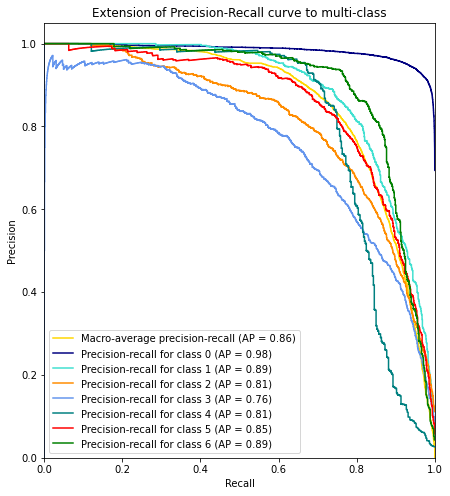

0.8577215783573549


In [44]:
prec_rec(best_classifier, X_test_50, y_test_50)